Loading data for ASML, NVDA, AMD, ^IXIC...

Loading data for ASML, NVDA, AMD, ^IXIC...


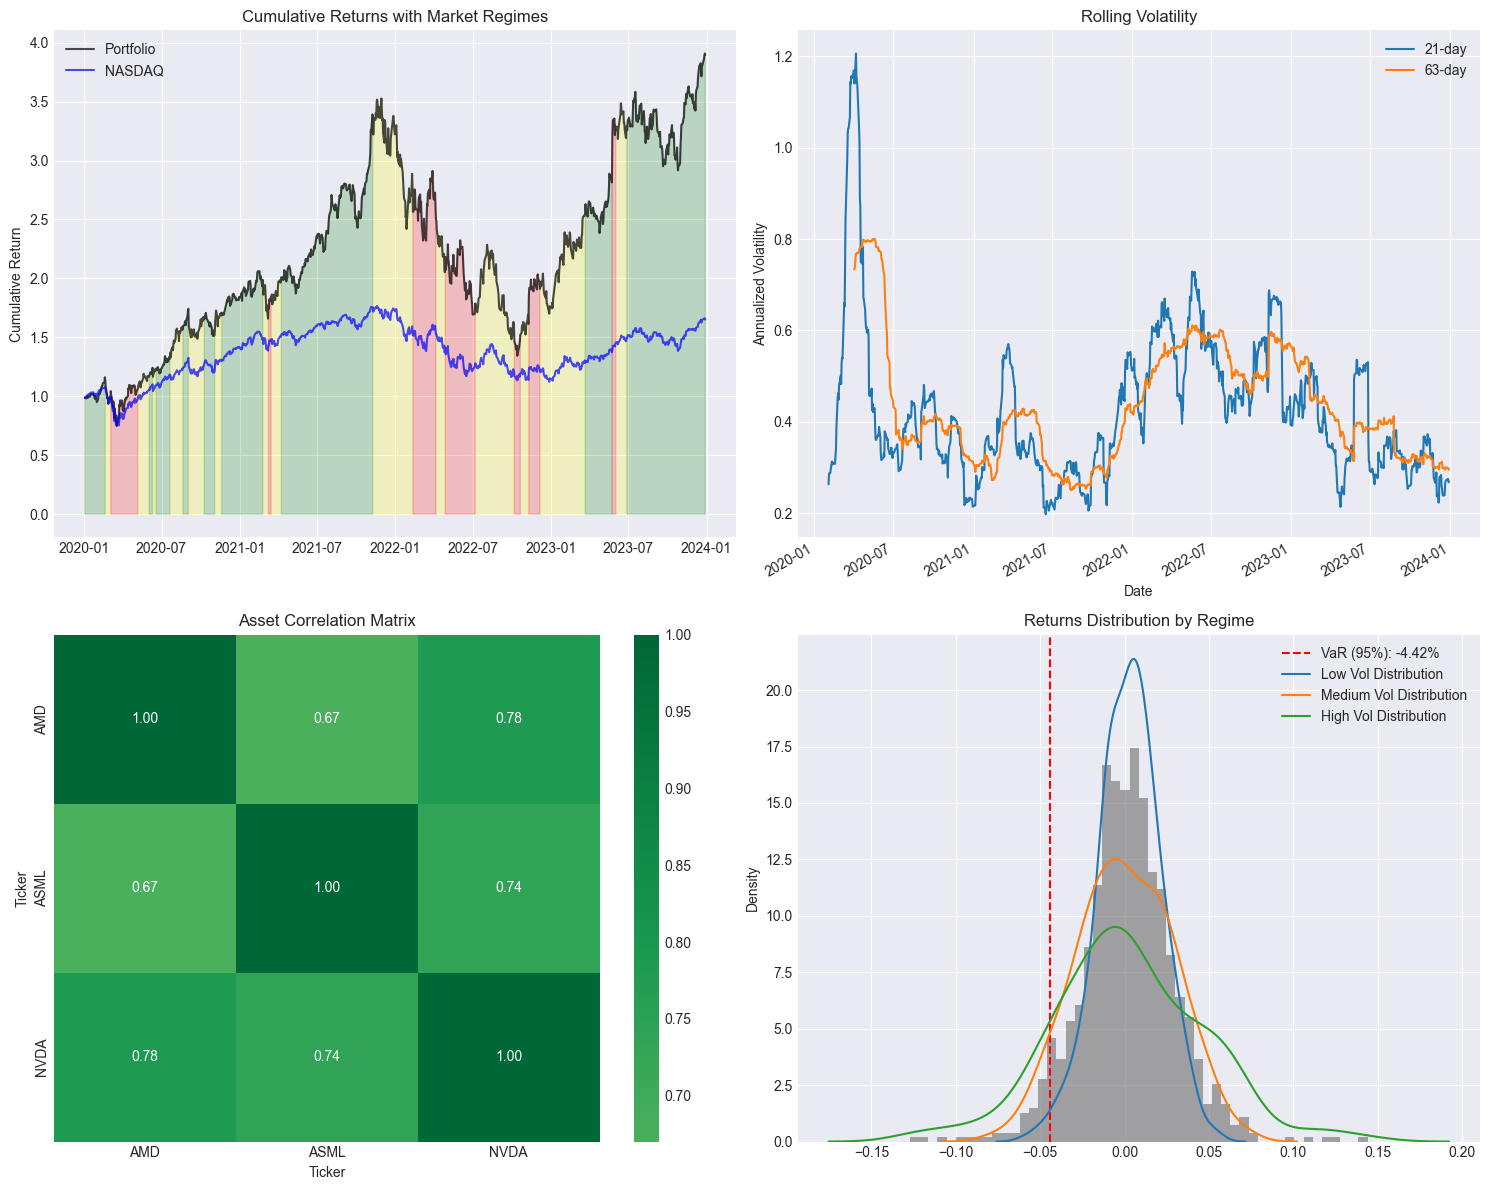


Risk Metrics Summary:
Portfolio Volatility: 45.64%
VaR (95%): -4.42%
Expected Shortfall (95%): -6.09%
Max Drawdown: -61.41%
Sharpe Ratio: 0.93

HMM Regime Analysis:

Low Vol Regime:
Mean Annual Return: 71.16%
Annualized Volatility: 29.37%
Sharpe Ratio: 2.42
% of Time: 47.9%

Medium Vol Regime:
Mean Annual Return: 1.88%
Annualized Volatility: 45.61%
Sharpe Ratio: 0.04
% of Time: 35.1%

High Vol Regime:
Mean Annual Return: 51.89%
Annualized Volatility: 71.33%
Sharpe Ratio: 0.73
% of Time: 17.0%

Regime Transition Probabilities:
             Low Vol    Medium Vol  High Vol
Low Vol     0.955752  2.429987e-02  0.019948
Medium Vol  0.015364  9.825306e-01  0.002106
High Vol    0.044768  3.690371e-46  0.955232

HMM Model Validation:

Information Ratio by Regime:
Low Vol: 2.42
Medium Vol: 0.04
High Vol: 0.73

Regime Persistence: 97.11%
Average Regime Duration: 33.5 days
Log Likelihood: -1919.28
AIC: 3866.55
BIC: 3935.33


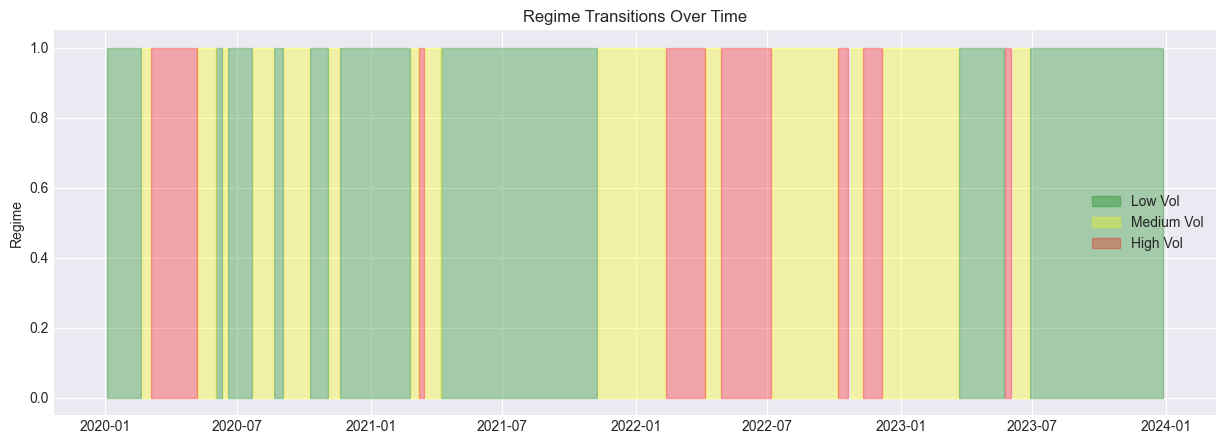


Performance Statistics:
Total Return: 289.63%
Annualized Return: 40.64%
Risk-Adjusted Return (Sharpe): 0.93


In [10]:
# Enhanced Risk Analysis Dashboard
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import yfinance as yf
from hmmlearn import hmm

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [15, 10]

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.visualization import RiskVisualizer
from src.regime import MarketRegimeDetector, RegimeConfig

# 1. Configure and Load Data
portfolio_config = PortfolioConfig(
    tickers=['ASML','NVDA', 'AMD', '^IXIC'],  # Including NASDAQ benchmark
    weights=[0.4, 0.4, 0.2, 0],
    start_date='2020-01-01',
    end_date='2024-01-01'
)

# Load market data
print(f"Loading data for {', '.join(portfolio_config.tickers)}...")
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()

# 2. Risk Analysis Configuration
risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.20,
    volatility_target=0.15
)

# Initialize RiskManager with weights
risk_manager = RiskManager(
    config=risk_config,
    risk_free_rate=0.05,
    weights=portfolio_config.weights[:-1]  # Exclude benchmark weight
)

# Calculate risk metrics for portfolio returns only (excluding benchmark)
portfolio_returns = market_data['returns'].iloc[:, :-1]  # Exclude benchmark
risk_metrics = risk_manager.calculate_metrics(portfolio_returns)

# 3. Regime Detection
regime_config = RegimeConfig(
    n_regimes=3,
    window_size=21,
    features=['returns', 'volatility']
)

detector = MarketRegimeDetector(regime_config)
portfolio_return_series = portfolio_returns.dot(portfolio_config.weights[:-1])
regimes = detector.fit_predict(portfolio_return_series)

# Get regime statistics and transition matrix
regime_stats = detector.get_regime_stats(portfolio_return_series, regimes)
transition_matrix = detector.get_transition_matrix()

# 4. Create Enhanced Visualization Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Cumulative Returns with Regime Overlay
cum_returns = (1 + market_data['returns']).cumprod()
portfolio_cum_returns = cum_returns.iloc[:, :-1].dot(portfolio_config.weights[:-1])
ax1.plot(cum_returns.index, portfolio_cum_returns, label='Portfolio', color='black', alpha=0.7)
ax1.plot(cum_returns.index, cum_returns['^IXIC'], label='NASDAQ', color='blue', alpha=0.7)

# Add regime overlay with fixed indexing
valid_idx = regimes.index.intersection(cum_returns.index)
for regime in detector.regime_labels:
    mask = (regimes[valid_idx] == regime)
    if mask.any():
        color = {'Low Vol': 'green', 'Medium Vol': 'yellow', 'High Vol': 'red'}[regime]
        ax1.fill_between(valid_idx, 0, portfolio_cum_returns[valid_idx], 
                        where=mask, color=color, alpha=0.2)

ax1.set_title('Cumulative Returns with Market Regimes')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True)

# Plot 2: Rolling Volatility
rolling_vol = risk_metrics['rolling_volatility']
rolling_vol.plot(ax=ax2)
ax2.set_title('Rolling Volatility')
ax2.set_ylabel('Annualized Volatility')
ax2.legend(['21-day', '63-day'])
ax2.grid(True)

# Plot 3: Correlation Matrix Heatmap
sns.heatmap(risk_metrics['correlation'],
            annot=True,
            cmap='RdYlGn',
            center=0,
            fmt='.2f',
            ax=ax3)
ax3.set_title('Asset Correlation Matrix')

# Plot 4: Returns Distribution with Regime Analysis
returns = portfolio_return_series
ax4.hist(returns, bins=50, density=True, alpha=0.7, color='gray')
ax4.axvline(risk_metrics['var_95'], color='r', linestyle='--', 
            label=f"VaR (95%): {risk_metrics['var_95']:.2%}")

# Add regime-specific distributions with fixed indexing
for regime in detector.regime_labels:
    regime_returns = returns[regimes.index].loc[regimes == regime]
    if len(regime_returns) > 0:
        sns.kdeplot(data=regime_returns, ax=ax4, 
                   label=f"{regime} Distribution")

ax4.set_title('Returns Distribution by Regime')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# 5. Print Enhanced Risk Analysis
print("\nRisk Metrics Summary:")
print("=" * 50)
print(f"Portfolio Volatility: {risk_metrics['portfolio_volatility']:.2%}")
print(f"VaR (95%): {risk_metrics['var_95']:.2%}")
print(f"Expected Shortfall (95%): {risk_metrics['expected_shortfall_95']:.2%}")
print(f"Max Drawdown: {risk_metrics['max_drawdown']:.2%}")
print(f"Sharpe Ratio: {risk_metrics['sharpe_ratio']:.2f}")

# 6. Print Regime Analysis
print("\nHMM Regime Analysis:")
print("=" * 50)
for regime, stats in regime_stats.items():
    print(f"\n{regime} Regime:")
    print(f"Mean Annual Return: {stats['mean_return']:.2%}")
    print(f"Annualized Volatility: {stats['volatility']:.2%}")
    print(f"Sharpe Ratio: {stats['sharpe']:.2f}")
    print(f"% of Time: {stats['frequency']:.1%}")

print("\nRegime Transition Probabilities:")
print("=" * 50)
print(transition_matrix)

# 7. Model Validation
validation_metrics = detector.validate_model(portfolio_return_series, regimes)

print("\nHMM Model Validation:")
print("=" * 50)
print("\nInformation Ratio by Regime:")
for regime, ir in validation_metrics['information_ratio'].items():
    print(f"{regime}: {ir:.2f}")

print(f"\nRegime Persistence: {validation_metrics['regime_persistence']:.2%}")
print(f"Average Regime Duration: {validation_metrics['avg_regime_duration']:.1f} days")
print(f"Log Likelihood: {validation_metrics['log_likelihood']:.2f}")
print(f"AIC: {validation_metrics['aic']:.2f}")
print(f"BIC: {validation_metrics['bic']:.2f}")

# 8. Regime Transition Visualization
plt.figure(figsize=(15, 5))
regime_colors = {'Low Vol': 'green', 'Medium Vol': 'yellow', 'High Vol': 'red'}
for regime in detector.regime_labels:
    mask = (regimes == regime)
    plt.fill_between(regimes.index, 0, 1, where=mask, 
                    color=regime_colors[regime], alpha=0.3, label=regime)

plt.title('Regime Transitions Over Time')
plt.ylabel('Regime')
plt.legend()
plt.grid(True)
plt.show()

# 9. Performance Statistics
print("\nPerformance Statistics:")
print("=" * 50)
total_return = portfolio_cum_returns.iloc[-1] - 1  # Using iloc instead of []
annualized_return = (1 + total_return) ** (252/len(returns)) - 1
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Risk-Adjusted Return (Sharpe): {risk_metrics['sharpe_ratio']:.2f}")

Loading data from 2020-01-01 to 2024-11-20...

Loading data for NVDA, ASML, INTC, ^IXIC...

Training model...

Predicting test set...


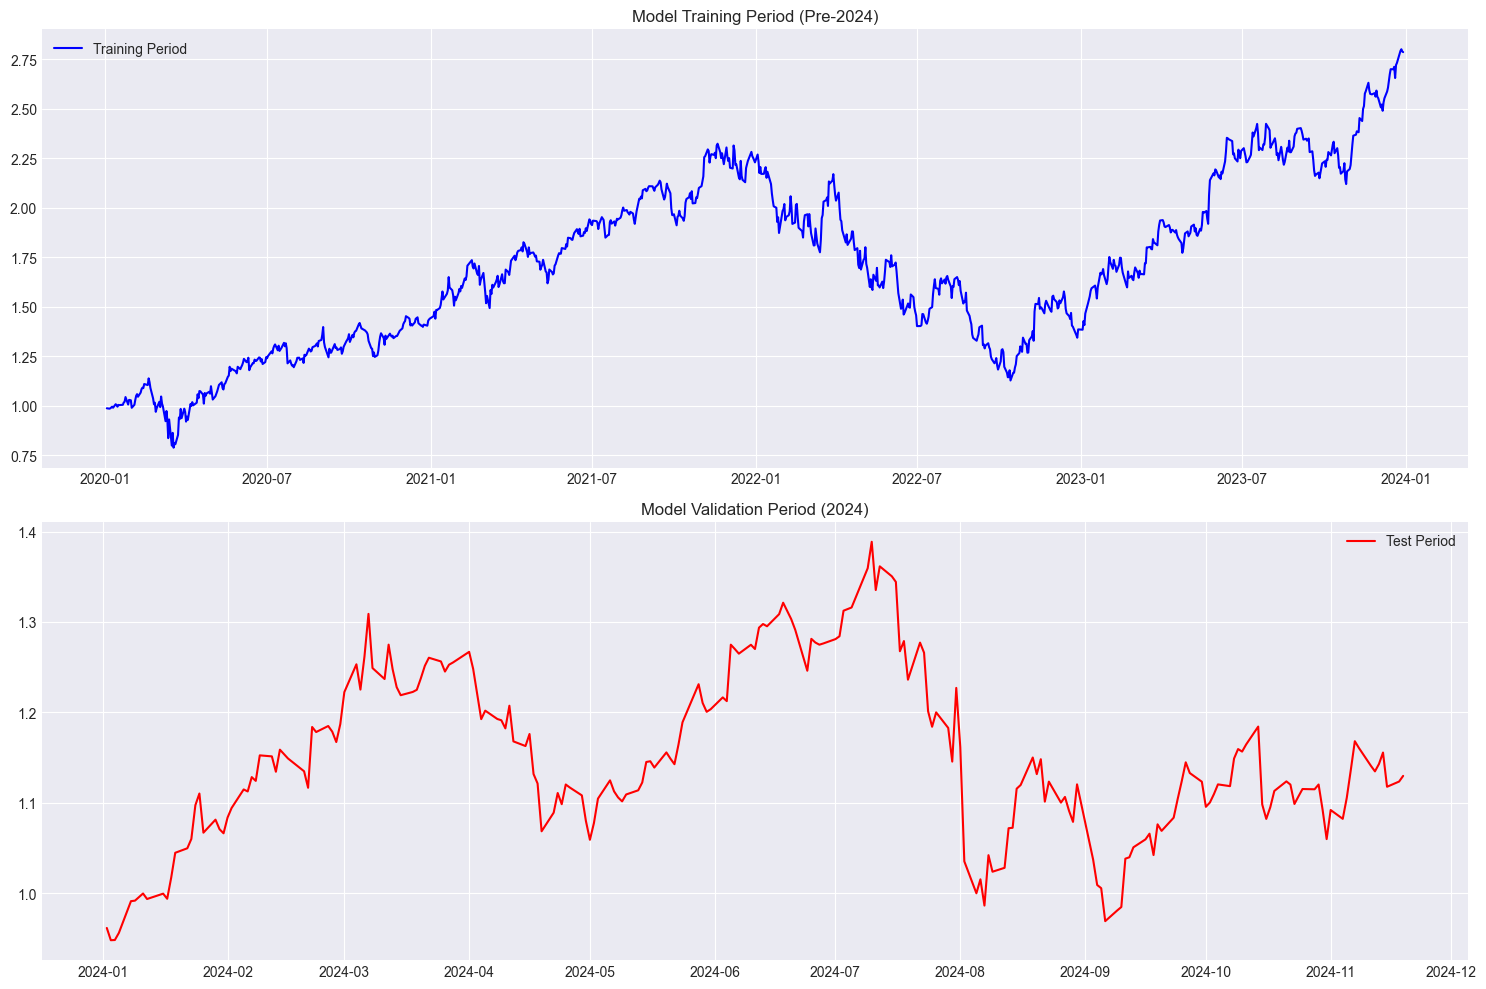


Performance Metrics:

Training Period (Pre-2024):
Total Return: 178.55%
Volatility: 36.13%
Sharpe Ratio: 0.89

Test Period (2024):
Total Return: 12.96%
Volatility: 36.74%
Sharpe Ratio: 0.56

Regime Distribution:

Training Period:
Low Vol       0.565174
Medium Vol    0.370149
High Vol      0.064677
Name: proportion, dtype: float64

Test Period:
Low Vol       0.683036
Medium Vol    0.165179
High Vol      0.151786
Name: proportion, dtype: float64


In [11]:
# Simple Backtesting Analysis
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.regime import MarketRegimeDetector, RegimeConfig

# Define periods
train_start = '2020-01-01'
train_end = '2024-01-01'
test_end = '2024-11-20'

print(f"Loading data from {train_start} to {test_end}...")

# Configure portfolio
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'ASML', 'INTC', '^IXIC'],
    weights=[0.3, 0.3, 0.3, 0.1],  # More balanced allocation
    start_date=train_start,  # Use train_start instead of start_date
    end_date=test_end       # Use test_end instead of end_date
)

# Load and clean data
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()
returns = market_data['returns'].iloc[:, :-1]  # Exclude benchmark
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

# Split into train and test
train_returns = returns[train_start:train_end]
test_returns = returns[train_end:test_end]

# Calculate portfolio returns
portfolio_returns_train = train_returns.dot(portfolio_config.weights[:-1])
portfolio_returns_test = test_returns.dot(portfolio_config.weights[:-1])

# Initialize models
regime_config = RegimeConfig(
    n_regimes=3,
    window_size=21,
    features=['returns', 'volatility']
)

risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.15,  # Tighter drawdown control
    volatility_target=0.30    # Adjusted for tech sector
)

# Train model
print("\nTraining model...")
detector = MarketRegimeDetector(regime_config)
train_regimes = detector.fit_predict(portfolio_returns_train)

# Predict test set
print("\nPredicting test set...")
test_regimes = detector.fit_predict(portfolio_returns_test)

# Calculate performance metrics
train_cum_returns = (1 + portfolio_returns_train).cumprod()
test_cum_returns = (1 + portfolio_returns_test).cumprod()

# Plot results
plt.figure(figsize=(15, 10))

# Plot 1: Training Period
plt.subplot(2, 1, 1)
plt.plot(train_cum_returns.index, train_cum_returns.values, 
         label='Training Period', color='blue')
plt.title('Model Training Period (Pre-2024)')
plt.legend()
plt.grid(True)

# Plot 2: Test Period
plt.subplot(2, 1, 2)
plt.plot(test_cum_returns.index, test_cum_returns.values, 
         label='Test Period', color='red')
plt.title('Model Validation Period (2024)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("=" * 50)
print("\nTraining Period (Pre-2024):")
print(f"Total Return: {(train_cum_returns.iloc[-1] - 1):.2%}")
print(f"Volatility: {portfolio_returns_train.std() * np.sqrt(252):.2%}")
print(f"Sharpe Ratio: {(portfolio_returns_train.mean() / portfolio_returns_train.std()) * np.sqrt(252):.2f}")

print("\nTest Period (2024):")
print(f"Total Return: {(test_cum_returns.iloc[-1] - 1):.2%}")
print(f"Volatility: {portfolio_returns_test.std() * np.sqrt(252):.2%}")
print(f"Sharpe Ratio: {(portfolio_returns_test.mean() / portfolio_returns_test.std()) * np.sqrt(252):.2f}")

# Regime Analysis
print("\nRegime Distribution:")
print("=" * 50)
print("\nTraining Period:")
print(train_regimes.value_counts(normalize=True))
print("\nTest Period:")
print(test_regimes.value_counts(normalize=True))

Loading data from 2020-01-01 to 2024-11-20...

Loading data for NVDA, ASML, INTC, ^IXIC...


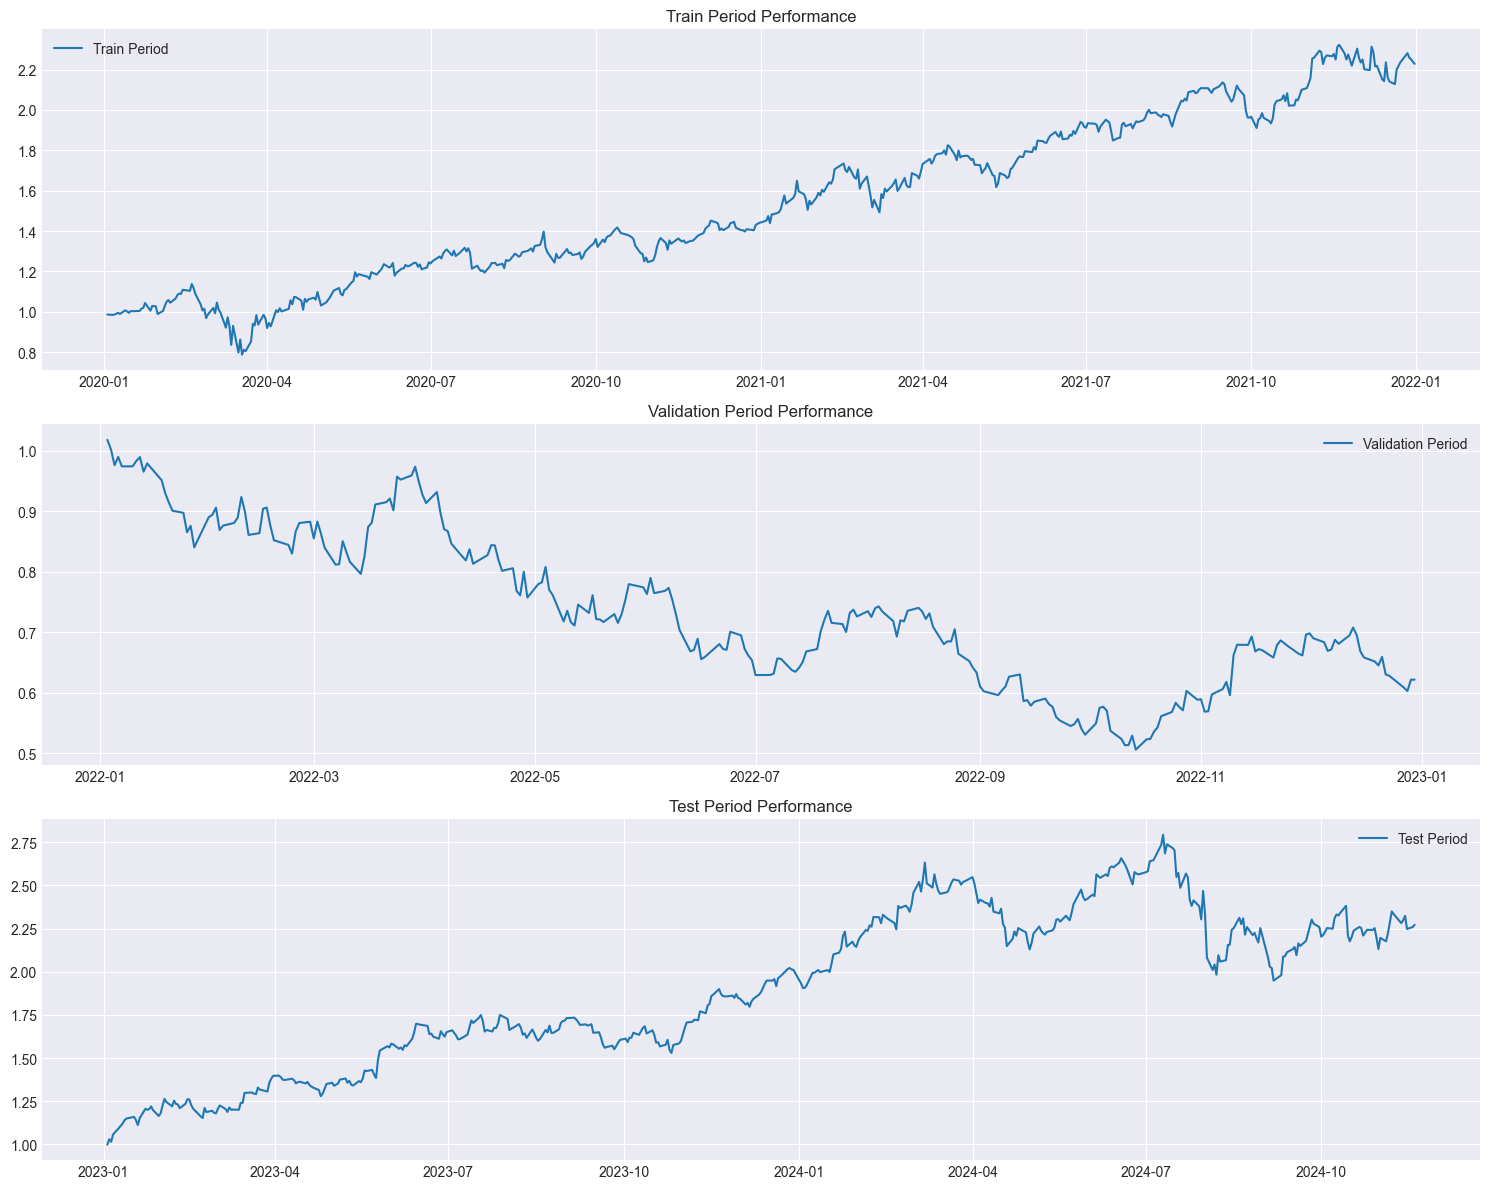


Train Period Metrics:
Total Return: 122.87%
Volatility: 36.27%
Sharpe Ratio: 1.29

Regime Distribution:
Low Vol       0.498016
Medium Vol    0.392857
High Vol      0.109127
Name: proportion, dtype: float64

Validation Period Metrics:
Total Return: -37.86%
Volatility: 42.52%
Sharpe Ratio: -0.91

Regime Distribution:
Low Vol       0.434263
Medium Vol    0.386454
High Vol      0.179283
Name: proportion, dtype: float64

Test Period Metrics:
Total Return: 127.19%
Volatility: 32.26%
Sharpe Ratio: 1.52

Regime Distribution:
Low Vol       0.556962
Medium Vol    0.364979
High Vol      0.078059
Name: proportion, dtype: float64


In [12]:
# Additional Validation Test
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.regime import MarketRegimeDetector, RegimeConfig

# Define multiple test periods
train_period = ('2020-01-01', '2022-01-01')
validation_period = ('2022-01-01', '2023-01-01')
test_period = ('2023-01-01', '2024-11-20')

print(f"Loading data from {train_period[0]} to {test_period[1]}...")

# Configure portfolio
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'ASML', 'INTC', '^IXIC'],
    weights=[0.3, 0.3, 0.3, 0.1],
    start_date=train_period[0],
    end_date=test_period[1]
)

# Load and clean data
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()
returns = market_data['returns'].iloc[:, :-1]
returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate portfolio returns for each period
train_returns = returns[train_period[0]:train_period[1]].dot(portfolio_config.weights[:-1])
validation_returns = returns[validation_period[0]:validation_period[1]].dot(portfolio_config.weights[:-1])
test_returns = returns[test_period[0]:test_period[1]].dot(portfolio_config.weights[:-1])

# Initialize model
regime_config = RegimeConfig(
    n_regimes=3,
    window_size=21,
    features=['returns', 'volatility']
)

detector = MarketRegimeDetector(regime_config)

# Get regimes for each period
train_regimes = detector.fit_predict(train_returns)
validation_regimes = detector.fit_predict(validation_returns)
test_regimes = detector.fit_predict(test_returns)

# Calculate metrics for each period
def calculate_metrics(returns):
    cum_returns = (1 + returns).cumprod()
    total_return = cum_returns.iloc[-1] - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    return {'return': total_return, 'volatility': volatility, 'sharpe': sharpe}

# Store returns and calculate metrics
portfolio_returns = {
    'train': train_returns,
    'validation': validation_returns,
    'test': test_returns
}

metrics = {
    period: calculate_metrics(rets) 
    for period, rets in portfolio_returns.items()
}

# Plot results
plt.figure(figsize=(15, 12))

# Plot returns for each period
for i, (period, returns) in enumerate(portfolio_returns.items()):
    plt.subplot(3, 1, i+1)
    cum_returns = (1 + returns).cumprod()
    plt.plot(cum_returns.index, cum_returns.values, 
             label=f'{period.capitalize()} Period')
    plt.title(f'{period.capitalize()} Period Performance')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print metrics
for period, m in metrics.items():
    print(f"\n{period.capitalize()} Period Metrics:")
    print("=" * 50)
    print(f"Total Return: {m['return']:.2%}")
    print(f"Volatility: {m['volatility']:.2%}")
    print(f"Sharpe Ratio: {m['sharpe']:.2f}")
    
    # Print regime distribution
    regimes = locals()[f'{period}_regimes']
    print("\nRegime Distribution:")
    print(regimes.value_counts(normalize=True))


Loading data for NVDA, ASML, INTC, ^IXIC...

Training Period Risk Analysis:
Portfolio Volatility: 40.31%
Value at Risk (95%): -3.64%
Expected Shortfall: -5.70%
Max Drawdown: -33.89%
Sharpe Ratio: 1.16
Volatility Ratio: 0.99
Position Size: 100.00%

Stress Test Results:
Worst Month Return: -7.82%
Worst Quarter Return: 2.70%
Recovery Time (days): 9.6

Validation Period Risk Analysis:
Portfolio Volatility: 47.25%
Value at Risk (95%): -4.62%
Expected Shortfall: -5.73%
Max Drawdown: -54.42%
Sharpe Ratio: -1.02
Volatility Ratio: 0.74
Position Size: 90.25%

Stress Test Results:
Worst Month Return: -21.67%
Worst Quarter Return: -36.06%
Recovery Time (days): 0.0

Test Period Risk Analysis:
Portfolio Volatility: 35.84%
Value at Risk (95%): -3.36%
Expected Shortfall: -5.04%
Max Drawdown: -33.20%
Sharpe Ratio: 1.38
Volatility Ratio: 0.90
Position Size: 100.00%

Stress Test Results:
Worst Month Return: -16.21%
Worst Quarter Return: -10.70%
Recovery Time (days): 9.8


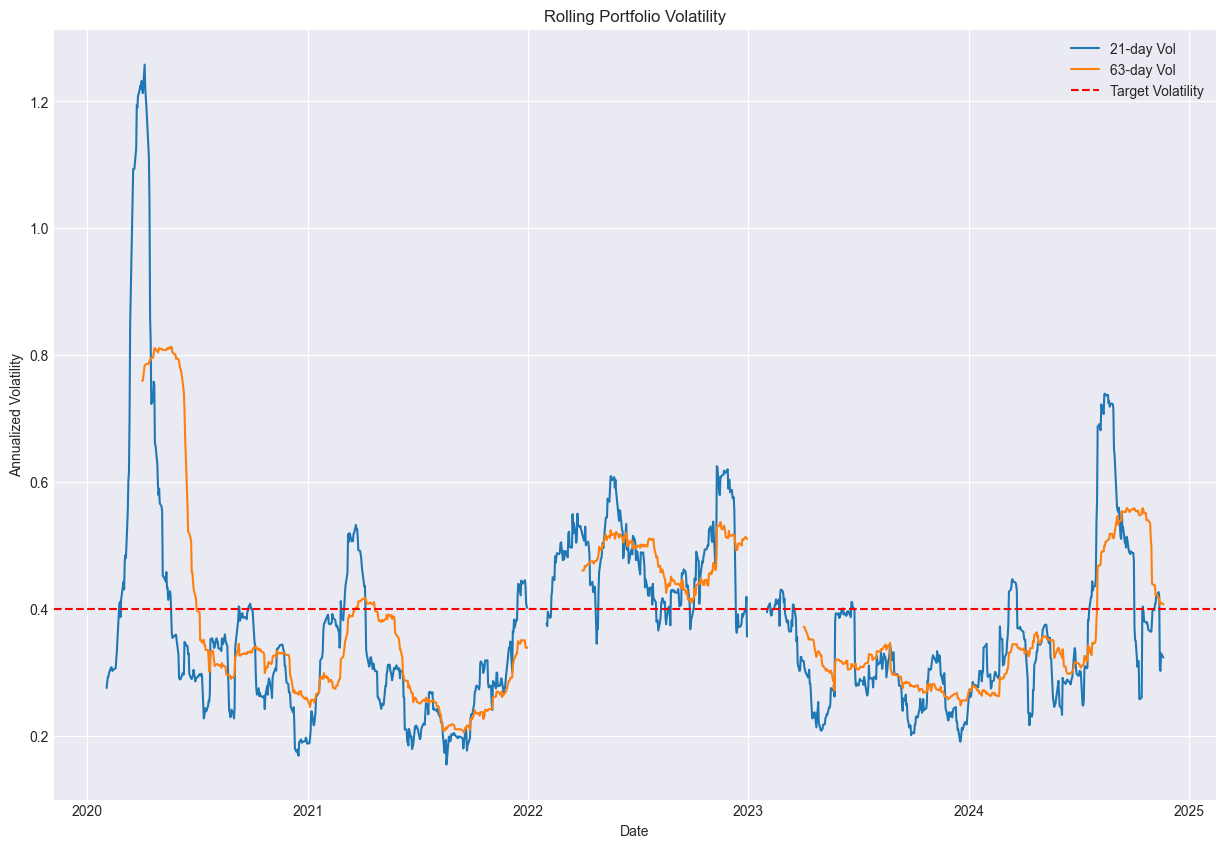


Risk Management Summary:

Position Sizing Recommendations:
Training Period: 100.00%
Validation Period: 90.25%
Test Period: 100.00%


In [15]:
# Risk Management Test
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from src.data import DataLoader, PortfolioConfig
from src.risk import RiskManager, RiskConfig
from src.regime import MarketRegimeDetector, RegimeConfig

# Define test periods
train_period = ('2020-01-01', '2022-01-01')
validation_period = ('2022-01-01', '2023-01-01')
test_period = ('2023-01-01', '2024-11-20')

# Configure portfolio and risk parameters
portfolio_config = PortfolioConfig(
    tickers=['NVDA', 'ASML', 'INTC', '^IXIC'],
    weights=[0.3, 0.3, 0.3, 0.1],
    start_date=train_period[0],
    end_date=test_period[1]
)

risk_config = RiskConfig(
    confidence_level=0.95,
    max_drawdown_limit=0.40,    # Increased from 0.20
    volatility_target=0.40,     # Adjusted based on historical vol
    position_limit=0.20         # Reduced from 0.40
)

# Load data
loader = DataLoader(portfolio_config)
market_data = loader.load_stocks()
returns = market_data['returns'].iloc[:, :-1]

# Initialize risk manager
risk_manager = RiskManager(risk_config, risk_free_rate=0.05)

def analyze_period(returns, period_name):
    metrics = risk_manager.calculate_metrics(returns)
    
    print(f"\n{period_name} Risk Analysis:")
    print("=" * 50)
    print(f"Portfolio Volatility: {metrics['portfolio_volatility']:.2%}")
    print(f"Value at Risk (95%): {metrics['var_95']:.2%}")
    print(f"Expected Shortfall: {metrics['expected_shortfall_95']:.2%}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2%}")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    
    if len(returns) > 21:  # Only print these metrics if enough data
        print(f"Volatility Ratio: {metrics.get('volatility_ratio', 1.0):.2f}")
        print(f"Position Size: {metrics.get('risk_adjusted_position', 1.0):.2%}")
        
        stress_test = metrics.get('stress_test', {})
        print("\nStress Test Results:")
        print(f"Worst Month Return: {stress_test.get('worst_month', 0):.2%}")
        print(f"Worst Quarter Return: {stress_test.get('worst_quarter', 0):.2%}")
        print(f"Recovery Time (days): {stress_test.get('recovery_time', 0):.1f}")
    
    return metrics

# Analyze each period
train_metrics = analyze_period(returns[train_period[0]:train_period[1]], "Training Period")
val_metrics = analyze_period(returns[validation_period[0]:validation_period[1]], "Validation Period")
test_metrics = analyze_period(returns[test_period[0]:test_period[1]], "Test Period")

# Plot rolling volatility
plt.figure(figsize=(15, 10))
rolling_vols = pd.concat([
    train_metrics['rolling_volatility'],
    val_metrics['rolling_volatility'],
    test_metrics['rolling_volatility']
])

plt.plot(rolling_vols.index, rolling_vols['21d'], label='21-day Vol')
plt.plot(rolling_vols.index, rolling_vols['63d'], label='63-day Vol')
plt.axhline(y=risk_config.volatility_target, color='r', linestyle='--', 
            label='Target Volatility')

plt.title('Rolling Portfolio Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Print summary with safe dictionary access
print("\nRisk Management Summary:")
print("=" * 50)
print("\nPosition Sizing Recommendations:")
print(f"Training Period: {train_metrics.get('risk_adjusted_position', 1.0):.2%}")
print(f"Validation Period: {val_metrics.get('risk_adjusted_position', 1.0):.2%}")
print(f"Test Period: {test_metrics.get('risk_adjusted_position', 1.0):.2%}")

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Configuration
test_config = {
    'tickers': ['NVDA', 'AMD', 'INTC'],
    'weights': [0.4, 0.4, 0.2],
    'start_date': '2023-01-01',
    'end_date': '2024-01-01',
    'alpaca_key_id': os.getenv('ALPACA_KEY_ID'),
    'alpaca_secret_key': os.getenv('ALPACA_SECRET_KEY'),
    'paper_trading': True
}

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [15, 10]

try:
    # 1. Initialize Configuration
    print("Configuration:")
    print("-" * 50)
    for key, value in test_config.items():
        if 'secret' not in key.lower():  # Don't print sensitive info
            print(f"{key}: {value}")
    
    # 2. Load Data
    portfolio_config = PortfolioConfig(**test_config)
    loader = DataLoader(portfolio_config)
    market_data = loader.load_stocks()
    
    # 3. Print Data Summary
    print("\nData Summary:")
    print("=" * 50)
    for ticker in test_config['tickers']:
        returns = market_data['returns'][ticker]
        print(f"\n{ticker}:")
        print(f"Annual Return: {returns.mean() * 252:.1%}")
        print(f"Annual Volatility: {returns.std() * np.sqrt(252):.1%}")
    
    print("\nData Loading Successful!")
    print("-" * 50)
    print("\nShape of data:")
    print(f"Close prices: {market_data['close'].shape}")
    print(f"Returns: {market_data['returns'].shape}")
    
    # 4. Visualizations
    # Plot 1: Normalized Prices
    plt.figure(figsize=(15, 8))
    for ticker in test_config['tickers']:
        plt.plot(
            market_data['close'].index,
            market_data['close'][ticker] / market_data['close'][ticker].iloc[0],
            label=ticker,
            linewidth=2
        )
    plt.title('Normalized Stock Prices', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (Normalized)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot 2: Rolling Volatility
    plt.figure(figsize=(15, 8))
    window = 21  # 21-day rolling window
    for ticker in test_config['tickers']:
        rolling_vol = market_data['returns'][ticker].rolling(window).std() * np.sqrt(252)
        plt.plot(rolling_vol.index, rolling_vol, label=f'{ticker} ({window}-day)', linewidth=2)
    plt.title(f'{window}-Day Rolling Volatility', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Annualized Volatility', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

    # Plot 3: Correlation Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        market_data['returns'].corr(),
        annot=True,
        cmap='RdYlBu',
        center=0,
        vmin=-1,
        vmax=1,
        square=True
    )
    plt.title('Correlation Matrix', fontsize=14)
    plt.show()

    # 5. Summary Statistics
    stats = loader.get_summary_statistics(market_data)
    print("\nPortfolio Statistics:")
    print("=" * 50)
    print(f"Annual Return: {stats['returns']['mean']:.2%}")
    print(f"Annual Volatility: {stats['returns']['std']:.2%}")
    print(f"Skewness: {stats['returns']['skew']:.2f}")
    print(f"Kurtosis: {stats['returns']['kurt']:.2f}")
    print("\nAverage Daily Volume:")
    for ticker in test_config['tickers']:
        print(f"{ticker}: {stats['daily_volume_avg'][ticker]:,.0f}")

except Exception as e:
    print(f"\nError: {str(e)}")
    raise
